In [39]:
from transformers import AutoImageProcessor, AutoModelForObjectDetection
from transformers import YolosFeatureExtractor, YolosForObjectDetection
import torch
from PIL import Image
import cv2
import matplotlib.pyplot as plt
import matplotlib.image as mpimg
import numpy as np
from tqdm import tqdm
import matplotlib.patches as patches
from ultralytics import YOLO
import pytesseract

## Cropping Cars

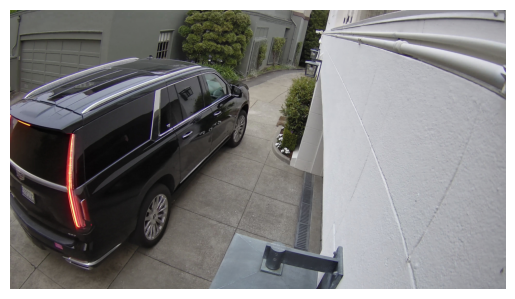

In [40]:
image = mpimg.imread('images/kevin.jpg')
plt.imshow(image)
plt.axis('off')
plt.show()

In [41]:
yolo_model = YOLO('yolov8m.pt')

results = yolo_model(image)
boxes = results[0].boxes.xyxy  # xyxy format: (x1, y1, x2, y2)
confidences = results[0].boxes.conf
classes = results[0].boxes.cls

cropped_images = []
for box, conf, cls in zip(boxes, confidences, classes):
    if conf > 0.9 and int(cls) == 2:  # Car label
        x1, y1, x2, y2 = map(int, box)
        cropped_image_np = image[y1:y2, x1:x2]
        cropped_images.append(cropped_image_np)


0: 384x640 1 car, 1 bench, 1 suitcase, 1 chair, 1 potted plant, 288.3ms
Speed: 1.6ms preprocess, 288.3ms inference, 0.5ms postprocess per image at shape (1, 3, 384, 640)


## Cropping plates

In [42]:
feature_extractor = YolosFeatureExtractor.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')
model = YolosForObjectDetection.from_pretrained('nickmuchi/yolos-small-finetuned-license-plate-detection')

In [43]:
inputs = feature_extractor(images=image, return_tensors="pt")
outputs = model(**inputs)

81 298 1385 1572


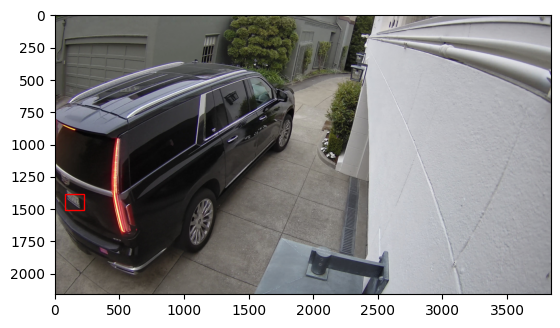

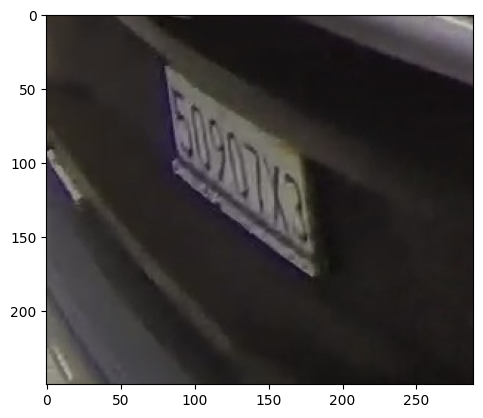

In [44]:
logits = outputs.logits
bboxes = outputs.pred_boxes

confidence_threshold = 0.5

probs = torch.softmax(logits, dim=-1)
keep = probs[..., 1] > confidence_threshold
image_height, image_width, _ = image.shape
bboxes = bboxes[keep]
bboxes[:, [0, 2]] *= image_width
bboxes[:, [1, 3]] *= image_height
np_bboxes = bboxes.detach().numpy()

fig, ax = plt.subplots()
ax.imshow(image)

plates = []
for bbox in np_bboxes:
    center_x, center_y, width, height = bbox
    
    plates.append(image[int(center_y-height):int(center_y+height), int(center_x-width):int(center_x+width)])
    print(int(center_x-width/2), int(center_x+width), int(center_y-height/2), int(center_y+height))
    
    rect = patches.Rectangle((center_x-width/2, center_y-height/2), width, height, linewidth=1, edgecolor='r', facecolor='none')
    ax.add_patch(rect)
    plt.show()
    
plt.imshow(plates[0])

In [45]:
cv2.imwrite('images/plate.jpg', plates[0])

True